## 分析数据规律以及异常值

In [1]:
import pandas as pd

datafile = 'data\\airlineCustomerValueAnalysis\data\\air_data.csv'
data = pd.read_csv(datafile, encoding='utf-8')
explore = data.describe().T
explore = explore[[ 'mean', 'std']]
explore.columns = [ '平均值', '方差']

explore.sort_values('方差', ascending=False)

,平均值,方差
SEG_KM_SUM,17123.878691,20960.844623
Points_Sum,12545.777100,20507.816700
MEMBER_NO,31494.500000,18183.213715
WEIGHTED_SEG_KM,12777.152439,17578.586695
BP_SUM,10925.081254,16339.486151
L1Y_Points_Sum,6638.739585,12601.819863
L1Y_BP_SUM,5558.360704,9351.956952
SUM_YR_2,5604.026014,8703.364247
P1Y_BP_SUM,5366.720550,8537.773021
Eli_Add_Point_Sum,1620.695847,8294.398955


## 丢弃异常数据 并保存

In [2]:
datafile = 'data\\airlineCustomerValueAnalysis\data\\air_data.csv'
cleanedfile = 'data\\airlineCustomerValueAnalysis\data\\air_data_cleaned.csv'# 清理后的数据

# 去掉票价为空的数据
data = data[(data['SUM_YR_1'].notnull()) & (data['SUM_YR_2'].notnull())]

# 丢弃票价0、平均折扣率不为0与总飞行公里数大于0的记录
criteria1 = data['SUM_YR_1'] != 0
criteria2 = data['SUM_YR_2'] != 0
data = data[criteria1 | criteria2]

data.to_csv(cleanedfile, index=False)  #保存

## 删除模型不需要的属性

In [3]:
datafile = 'data\\airlineCustomerValueAnalysis\data\\air_data_cleaned.csv'
data = pd.read_csv(datafile, encoding='utf-8')

data = data[['LOAD_TIME', 'FFP_DATE', 'LAST_TO_END', 'FLIGHT_COUNT', 'SEG_KM_SUM', 'avg_discount']]

## 构建属性

In [4]:
data.insert(
    loc = data.columns.get_loc('FFP_DATE') + 1,
    column = 'L',
    value = (pd.to_datetime(data['LOAD_TIME']) - pd.to_datetime(data['FFP_DATE'])).dt.days
)

data = data.loc[:,'L':]
data.columns = ['L', 'R', 'F', 'M', 'C']
data.head(5)

,L,R,F,M,C
0,2706,1,210,580717,0.961639
1,2597,7,140,293678,1.252314
2,2615,11,135,283712,1.254676
3,2047,97,23,281336,1.090870
4,1816,5,152,309928,0.970658


## 标准化处理

In [5]:
zscoredfile = 'data\\airlineCustomerValueAnalysis\data\Zscored_data.csv'

data = (data - data.mean()) / (data.std())
data.columns = ['Z'+i for i in data.columns]
data.to_csv(zscoredfile, index=False)
data.head(10)


,ZL,ZR,ZF,ZM,ZC
0,1.435707,-0.944948,14.034016,26.761154,1.295540
1,1.307152,-0.911894,9.073213,13.126864,2.868176
2,1.328381,-0.889859,8.718869,12.653481,2.880950
3,0.658476,-0.416098,0.781585,12.540622,1.994714
4,0.386032,-0.922912,9.923636,13.898736,1.344335
5,0.887281,-0.515257,5.671519,13.169947,1.328291
6,1.701075,-0.944948,6.309337,12.811656,1.315599
7,-0.043274,-0.933930,4.325015,12.820586,1.297873
8,-0.543344,-0.917403,3.120249,14.447881,0.575103
9,-0.145883,-0.867824,3.687198,16.993157,-0.076664


## 确认最优的K值

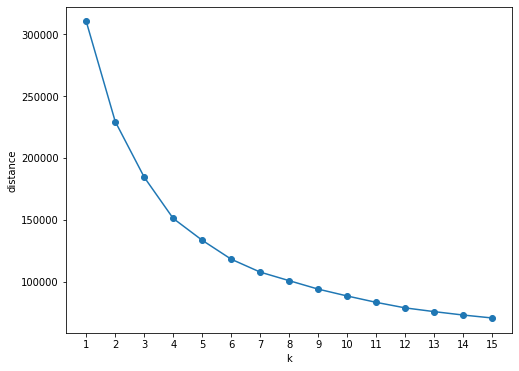

In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

distortions = []
#评估簇数是否合适/越小越好

plt.figure(figsize=(8,6))
for i in range(1,16,1): #列出群个数为1到16时的K值与质心距离
    clf = KMeans(n_clusters=i)
    s = clf.fit(data)
    distortions.append(clf.inertia_)
k = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
plt.scatter(k, distortions)
plt.plot(k, distortions)
plt.xlabel("k")
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])  # 指定x轴刻度的数目与取值
plt.ylabel("distance")
plt.show()

## 客户K-Means聚类 K = 5

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
datafile = 'data\\airlineCustomerValueAnalysis\data\Zscored_data.csv'
k = 5

data = pd.read_csv(datafile)

kmodel = KMeans(n_clusters=k)
kmodel.fit(data)

def get_cluster(data):
    labels = pd.Series(kmodel.labels_)
    nums = labels.value_counts().sort_index()
    types = pd.Series(['客户群'+str(i) for i in range(1, 6)])
    centers = pd.DataFrame(kmodel.cluster_centers_, columns=data.columns)
    new_data = pd.concat([types, nums, centers], axis='columns')
    new_data.columns = ['cluster_names', 'cluster_num', 'ZL', 'ZR', 'ZF', 'ZM', 'ZC']
    
    return new_data

data = get_cluster(data)
data.head(5)

,cluster_names,cluster_num,ZL,ZR,ZF,ZM,ZC
0,客户群1,12427,-0.317026,1.668934,-0.573165,-0.537574,-0.139294
1,客户群2,25323,-0.695927,-0.410809,-0.166123,-0.167622,-0.212948
2,客户群3,5311,0.481980,-0.798458,2.486021,2.425611,0.283243
3,客户群4,16040,1.154592,-0.369712,-0.094550,-0.103335,-0.132643
4,客户群5,2943,0.164984,-0.061538,-0.120008,-0.100534,2.642666


## 客户价值分析

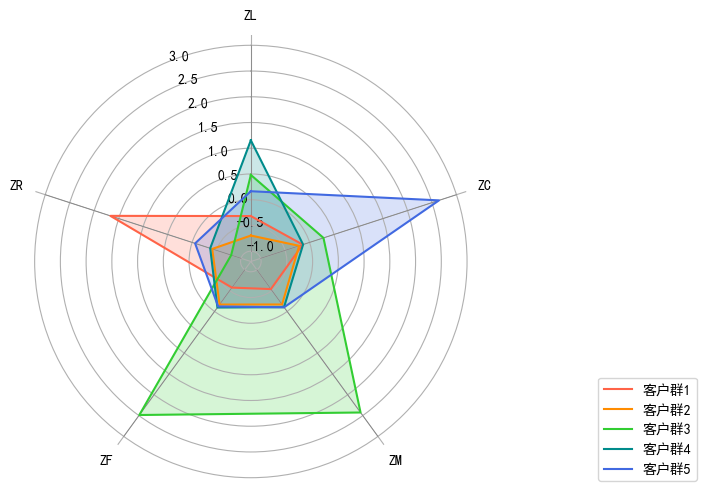

In [10]:
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def plot_radar(data):
    colors = ['tomato', 'darkorange', 'limegreen', 'darkcyan', 'royalblue']
    names = data['cluster_names'].tolist()
    labels = data.columns.tolist()[2:]
    centers = pd.concat([data.iloc[:, 2:], data.iloc[:, 2]], axis=1)
    centers = np.array(centers)
    n = len(labels)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    
    fig = plt.figure(figsize=(6, 6), dpi=100)
    ax = fig.add_subplot(111, polar=True)
    
    floor = np.floor(centers.min())
    ceil = np.ceil(centers.max())
    
    for i in range(n):
        ax.plot([angles[i], angles[i]], [floor, ceil], lw=0.5, color='grey')
    
    for i in range(len(names)):
        ax.plot(angles, centers[i], colors[i], label=names[i])
        plt.fill(angles, centers[i], facecolor=colors[i], alpha=0.2)
    
    ans = angles * 180 / np.pi
    ax.set_thetagrids(ans[:-1], labels)
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0.0))
    
    ax.set_theta_zero_location('N')
    ax.spines['polar'].set_visible(False)
    
    plt.show()

plot_radar(data)